In [1]:
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

In [2]:
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [3]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        folder_path = os.path.join(dir, label)
        if not os.path.isdir(folder_path):  # skip files like .DS_Store
            continue
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

In [4]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

happy completed
sad completed
fear completed
surprise completed
neutral completed
angry completed
disgust completed


In [5]:
print(train)

                                image    label
0         images/train/happy/3578.jpg    happy
1        images/train/happy/16988.jpg    happy
2         images/train/happy/2666.jpg    happy
3         images/train/happy/5109.jpg    happy
4        images/train/happy/11981.jpg    happy
...                               ...      ...
28816  images/train/disgust/10112.jpg  disgust
28817  images/train/disgust/21668.jpg  disgust
28818   images/train/disgust/7049.jpg  disgust
28819   images/train/disgust/9716.jpg  disgust
28820   images/train/disgust/3561.jpg  disgust

[28821 rows x 2 columns]


In [6]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

happy completed
sad completed
fear completed
surprise completed
neutral completed
angry completed
disgust completed


In [7]:
print(test)
print(test['image'])

                              image    label
0       images/test/happy/23933.jpg    happy
1       images/test/happy/24906.jpg    happy
2       images/test/happy/18033.jpg    happy
3       images/test/happy/15271.jpg    happy
4       images/test/happy/26888.jpg    happy
...                             ...      ...
7061  images/test/disgust/20761.jpg  disgust
7062  images/test/disgust/28710.jpg  disgust
7063  images/test/disgust/23876.jpg  disgust
7064   images/test/disgust/9460.jpg  disgust
7065  images/test/disgust/35580.jpg  disgust

[7066 rows x 2 columns]
0         images/test/happy/23933.jpg
1         images/test/happy/24906.jpg
2         images/test/happy/18033.jpg
3         images/test/happy/15271.jpg
4         images/test/happy/26888.jpg
                    ...              
7061    images/test/disgust/20761.jpg
7062    images/test/disgust/28710.jpg
7063    images/test/disgust/23876.jpg
7064     images/test/disgust/9460.jpg
7065    images/test/disgust/35580.jpg
Name: image, Leng

In [8]:
from tqdm.notebook import tqdm

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,color_mode="grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [10]:
train_features = extract_features(train['image']) 

  0%|          | 0/28821 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [12]:
x_train = train_features/255.0
x_test = test_features/255.0

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [15]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [16]:
y_train = to_categorical(y_train,num_classes = 7)
y_test = to_categorical(y_test,num_classes = 7)

In [17]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(7, activation='softmax'))

/Users/harshchahal/Desktop/Face emotion detection/FED/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [23]:
model.fit(x= x_train,y = y_train, batch_size = 128, epochs = 100, validation_data = (x_test,y_test))

Epoch 1/100
  7/226 ━━━━━━━━━━━━━━━━━━━━ 2:50 781ms/step - accuracy: 0.6735 - loss: 0.8662

KeyboardInterrupt: 

In [22]:
model_json = model.to_json()
with open("emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

In [24]:
from keras.models import model_from_json

In [25]:
json_file = open("emotiondetector.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("emotiondetector.h5")

In [26]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [29]:
def ef(image):
    img = load_img(image,color_mode="grayscale")
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

In [44]:
image = 'images/train/fear/308.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
model prediction is  fear


In [45]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
model prediction is  fear


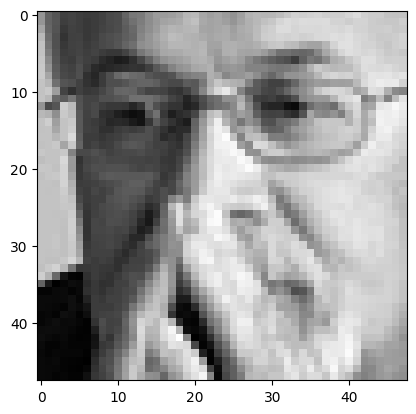

In [48]:
image = 'images/train/fear/308.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
model prediction is  happy


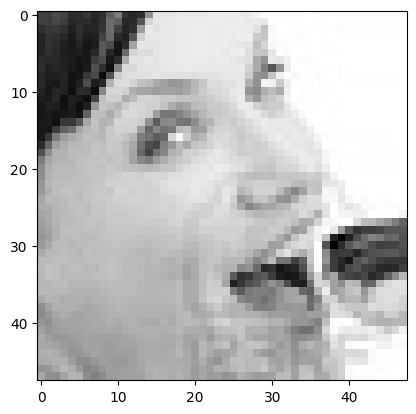

In [49]:
image = 'images/train/happy/34.jpg'  #Few trial run to see the accuracy
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
model prediction is  surprise


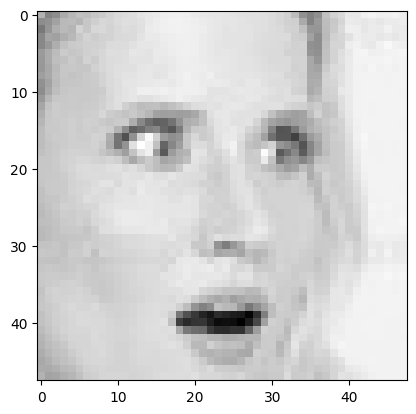

In [50]:
image = 'images/train/surprise/61.jpg'
print("original image is of surprise")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
model prediction is  disgust


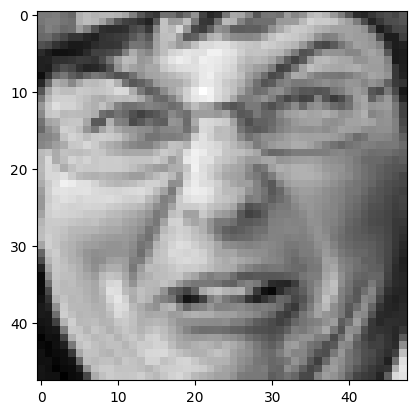

In [51]:
image = 'images/train/disgust/299.jpg'
print("original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')